<h1> Patient Arrival Rate </h1>

This notebook was used to analysis the patient arrivals in the region and test for seasonality.

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import truncnorm
from scipy.stats import kruskal
import scipy.stats as stats

import matplotlib.pyplot as plt
#seaborn settings
sns.set_theme(style="whitegrid",palette="colorblind",font_scale=1.5)
sns.set_context("paper")
sns.despine(left=True,right=True)
import warnings
warnings.filterwarnings("ignore")

<Figure size 640x480 with 0 Axes>

In [79]:
df = pd.read_csv("example_dataset.csv")

<h2>Data preparation </h2>

In [80]:
df['season'] = pd.to_datetime(df['start_date']).dt.month.apply(lambda x: 'winter' if x in [12,1,2] else 'spring' if x in [3,4,5] else 'summer' if x in [6,7,8] else 'autumn').astype('string')
df['month'] = pd.to_datetime(df['start_date']).dt.month
df_filtered = df[df['stay_number'] == 1]



In [81]:
#show all ward levels
df_filtered['ward_level'].value_counts()

ward_level
NICU      10
Medium     7
High       5
Name: count, dtype: int64

In [82]:
#unique regions
df_filtered['region'].value_counts()    

region
Region C    8
Region B    7
Region A    7
Name: count, dtype: int64

<h2>Patient admissions </h2>

In [83]:
#df_inside by year
df_filtered['year'] = pd.to_datetime(df_filtered['start_date']).dt.year
df_filtered['year'].value_counts()

year
2022    8
2023    6
2020    5
2021    3
Name: count, dtype: int64

In [84]:
daily_admissions = pd.to_datetime(df_filtered['start_date']).dt.date.value_counts().sort_index().reset_index()
daily_admissions.columns = ['date', 'admissions']

In [85]:
#min date max date date range
min_date = pd.to_datetime(df_filtered['start_date']).min()
max_date = pd.to_datetime(df_filtered['start_date']).max()
date_range = pd.date_range(start=min_date, end=max_date)

#missing dates
missing_dates = date_range[~date_range.isin(daily_admissions['date'])]
missing_dates

DatetimeIndex(['2020-05-22', '2020-05-23', '2020-05-24', '2020-05-25',
               '2020-05-26', '2020-05-27', '2020-05-28', '2020-05-29',
               '2020-05-30', '2020-05-31',
               ...
               '2023-10-05', '2023-10-06', '2023-10-07', '2023-10-08',
               '2023-10-09', '2023-10-10', '2023-10-11', '2023-10-12',
               '2023-10-13', '2023-10-14'],
              dtype='datetime64[ns]', length=1222, freq=None)

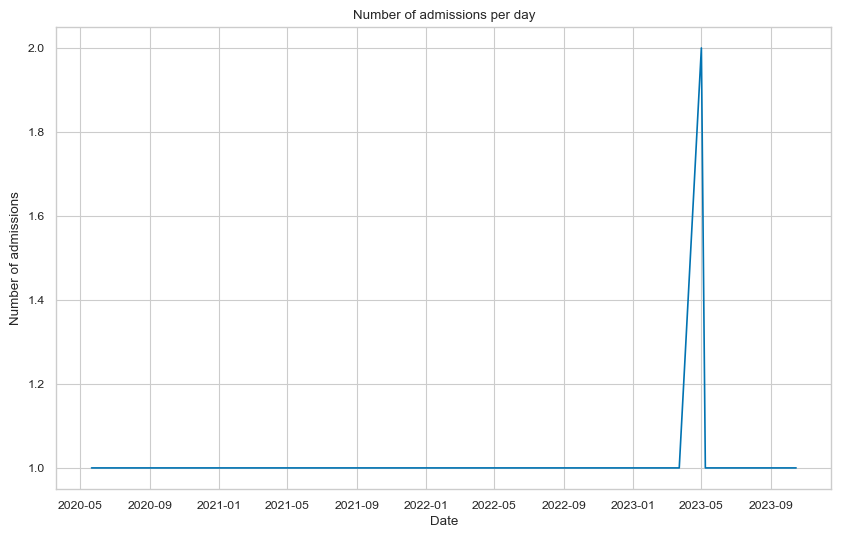

In [86]:
#plot daily admissions
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=daily_admissions, x='date', y='admissions', ax=ax)
plt.title('Number of admissions per day')
plt.xlabel('Date')
plt.ylabel('Number of admissions')
plt.show()

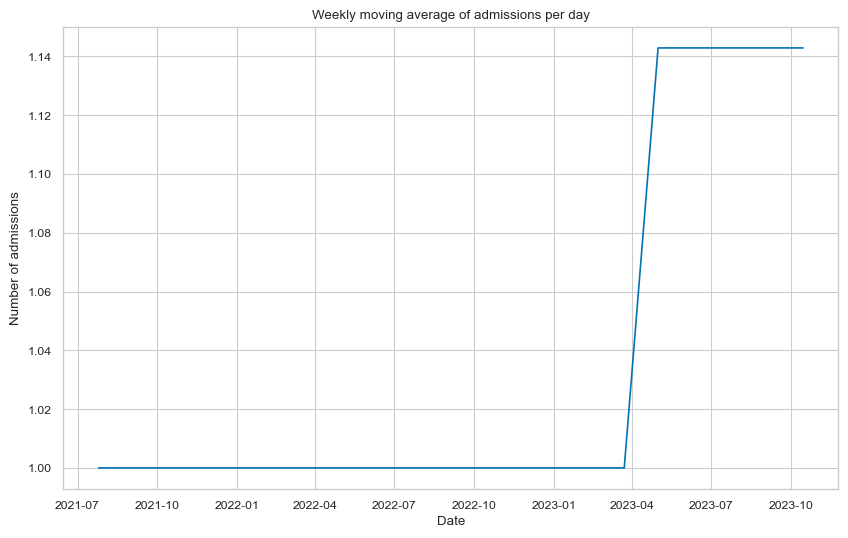

In [87]:
#plot 3 day moving average

daily_admissions['7_day_avg'] = daily_admissions['admissions'].rolling(7).mean()
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=daily_admissions, x='date', y='7_day_avg', ax=ax)
plt.title('Weekly moving average of admissions per day')
plt.xlabel('Date')


plt.ylabel('Number of admissions')
plt.show()


In [88]:
#first date
df_filtered['start_date'].min()

'1/27/22'

In [89]:
#set date to datetime in daily_admissions
daily_admissions['date'] = pd.to_datetime(daily_admissions['date'])


In [90]:
daily_admissions_filtered = daily_admissions[pd.to_datetime(daily_admissions['date']) <= pd.to_datetime(max_date)]

In [91]:
missing_dates = date_range[~date_range.isin(daily_admissions_filtered['date'])]
missing_dates
#fill missing with 0
daily_admissions_filtered = daily_admissions_filtered.set_index('date').reindex(date_range)

In [92]:
#fill admissions with 0 for missing dates
daily_admissions_filtered['admissions'] = daily_admissions_filtered['admissions'].fillna(0)

In [93]:
daily_admissions_filtered = daily_admissions[pd.to_datetime(daily_admissions['date']) <= pd.to_datetime(max_date)]

In [94]:
#describe daily admissions
print(daily_admissions_filtered['admissions'].describe())

count    21.000000
mean      1.047619
std       0.218218
min       1.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       2.000000
Name: admissions, dtype: float64


1.9999999999974236 5.536887428255214e-14


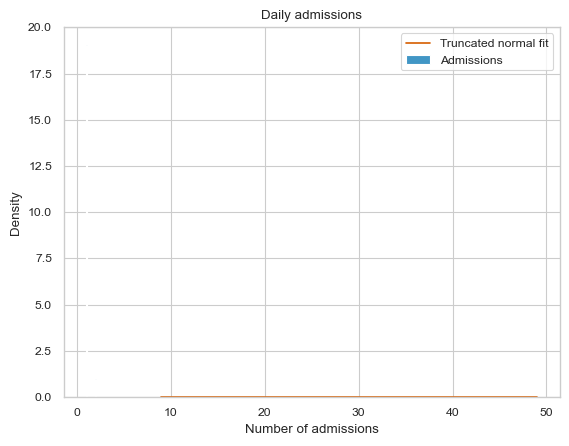

In [95]:
lower_bound = 9
upper_bound = 49

mu,std = np.mean(daily_admissions_filtered['admissions']), np.std(daily_admissions_filtered['admissions'])
a,b = (lower_bound - mu) / std, (upper_bound - mu) / std
fitted_params = truncnorm.fit(daily_admissions_filtered['admissions'], a, b, loc=mu, scale=std)
fitted_mu, fitted_std = fitted_params[2], fitted_params[3]
print(fitted_mu, fitted_std)
x = np.linspace(lower_bound, upper_bound, 100)
fitted_pdf = truncnorm.pdf(x, a, b, loc=fitted_mu, scale=fitted_std)
sns.histplot(daily_admissions_filtered['admissions'], bins=20, stat='density')
plt.plot(x, fitted_pdf, 'r')
plt.title('Daily admissions')
plt.xlabel('Number of admissions')
plt.ylabel('Density')
plt.legend(['Truncated normal fit', 'Admissions'])
plt.show()

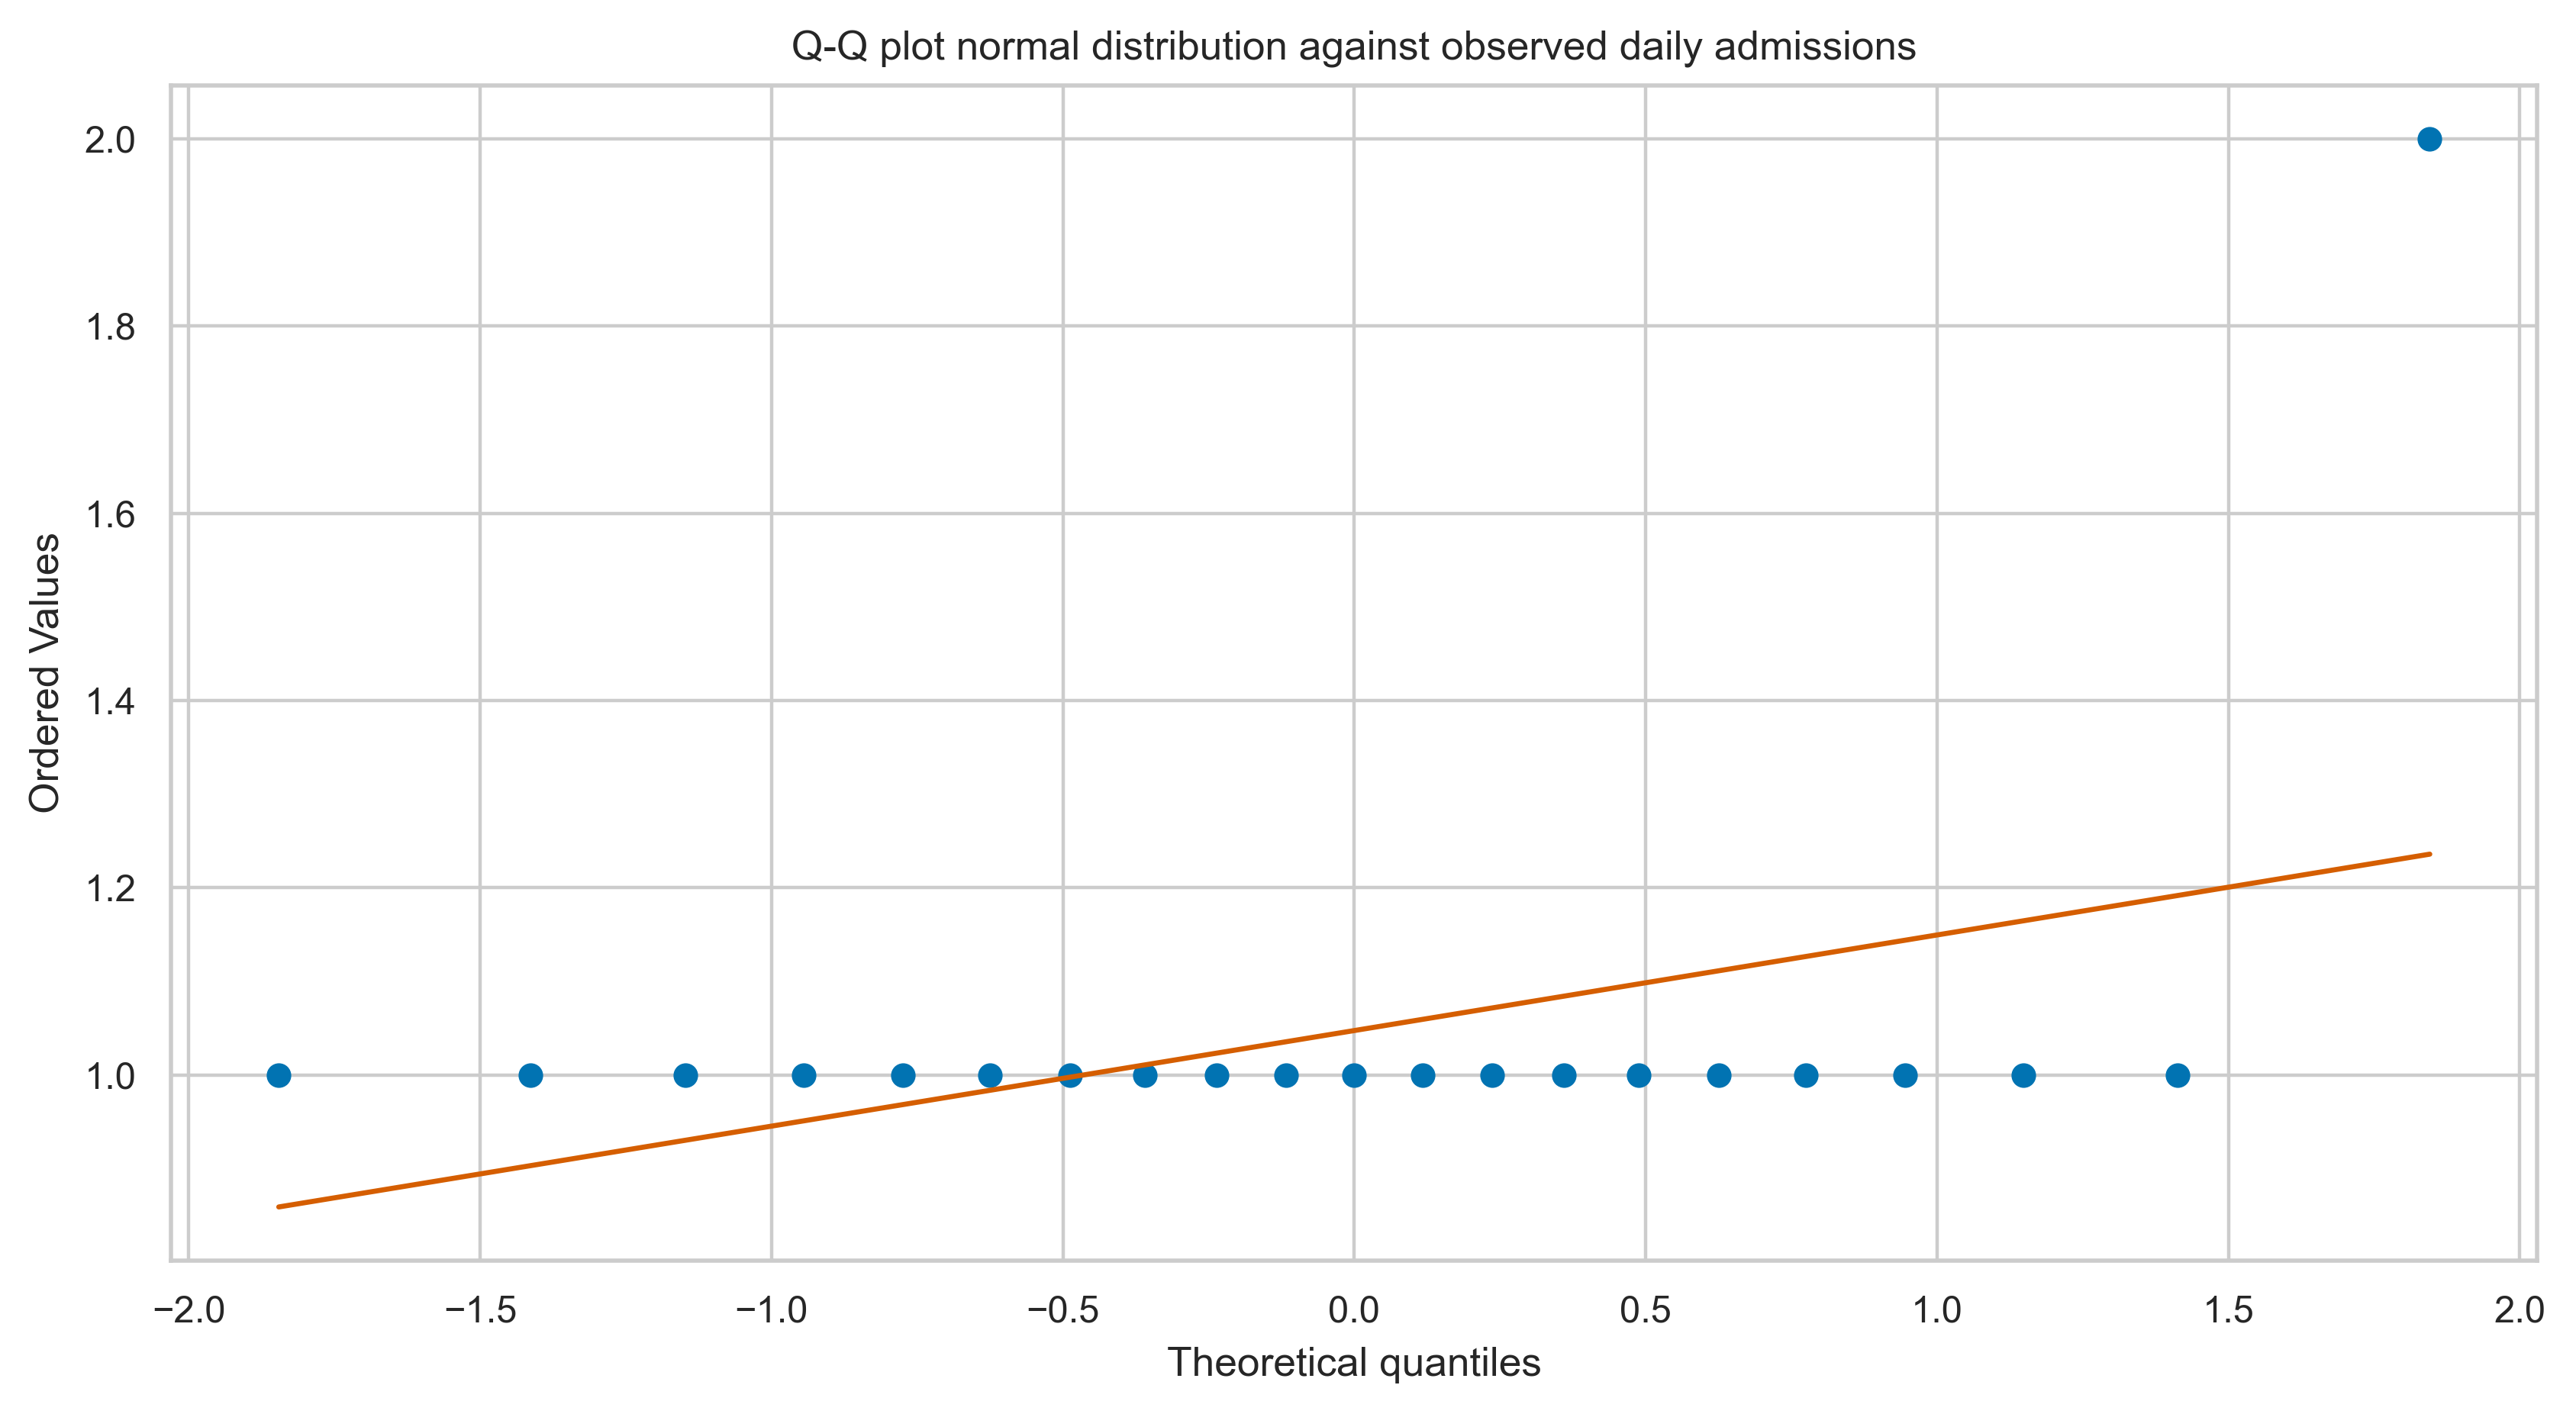

In [96]:
from scipy.stats import probplot
plt.figure(figsize=(10,5),dpi=400)

res = probplot(daily_admissions_filtered['admissions'], dist="norm",  plot=plt)
plt.title('Q-Q plot normal distribution against observed daily admissions')
plt.show()

In [97]:

 
# Sample data (replace this with your actual data)
data = daily_admissions_filtered['admissions']
 

 
def normal_cdf(x, mu, sigma):
    return stats.norm.cdf(x, mu, sigma)



In [98]:
std = np.std(data)


In [99]:
lambda_,std = fitted_params[2],fitted_params[3]
# Perform the one-sample K-S test

ks_stat, p_value = stats.kstest(data, normal_cdf, args=(lambda_,std))
 
print(f'K-S Statistic: {ks_stat}')
print(f'P-Value: {p_value}')
 
# Interpretation based on the significance level
alpha = 0.05
if p_value > alpha:
    print("Fail to reject the null hypothesis. The data fits a Normal distribution.")
else:
    print("Reject the null hypothesis. The data does not fit a Normal distribution.")

K-S Statistic: 0.9523809523809523
P-Value: 3.423141142282118e-28
Reject the null hypothesis. The data does not fit a Normal distribution.


In [100]:
#average admission count per season
daily_admissions_filtered['season'] = pd.to_datetime(daily_admissions_filtered['date']).dt.month.apply(lambda x: 'winter' if x in [12,1,2] else 'spring' if x in [3,4,5] else 'summer' if x in [6,7,8] else 'autumn').astype('string')
daily_admissions_filtered['month'] = pd.to_datetime(daily_admissions_filtered['date']).dt.month


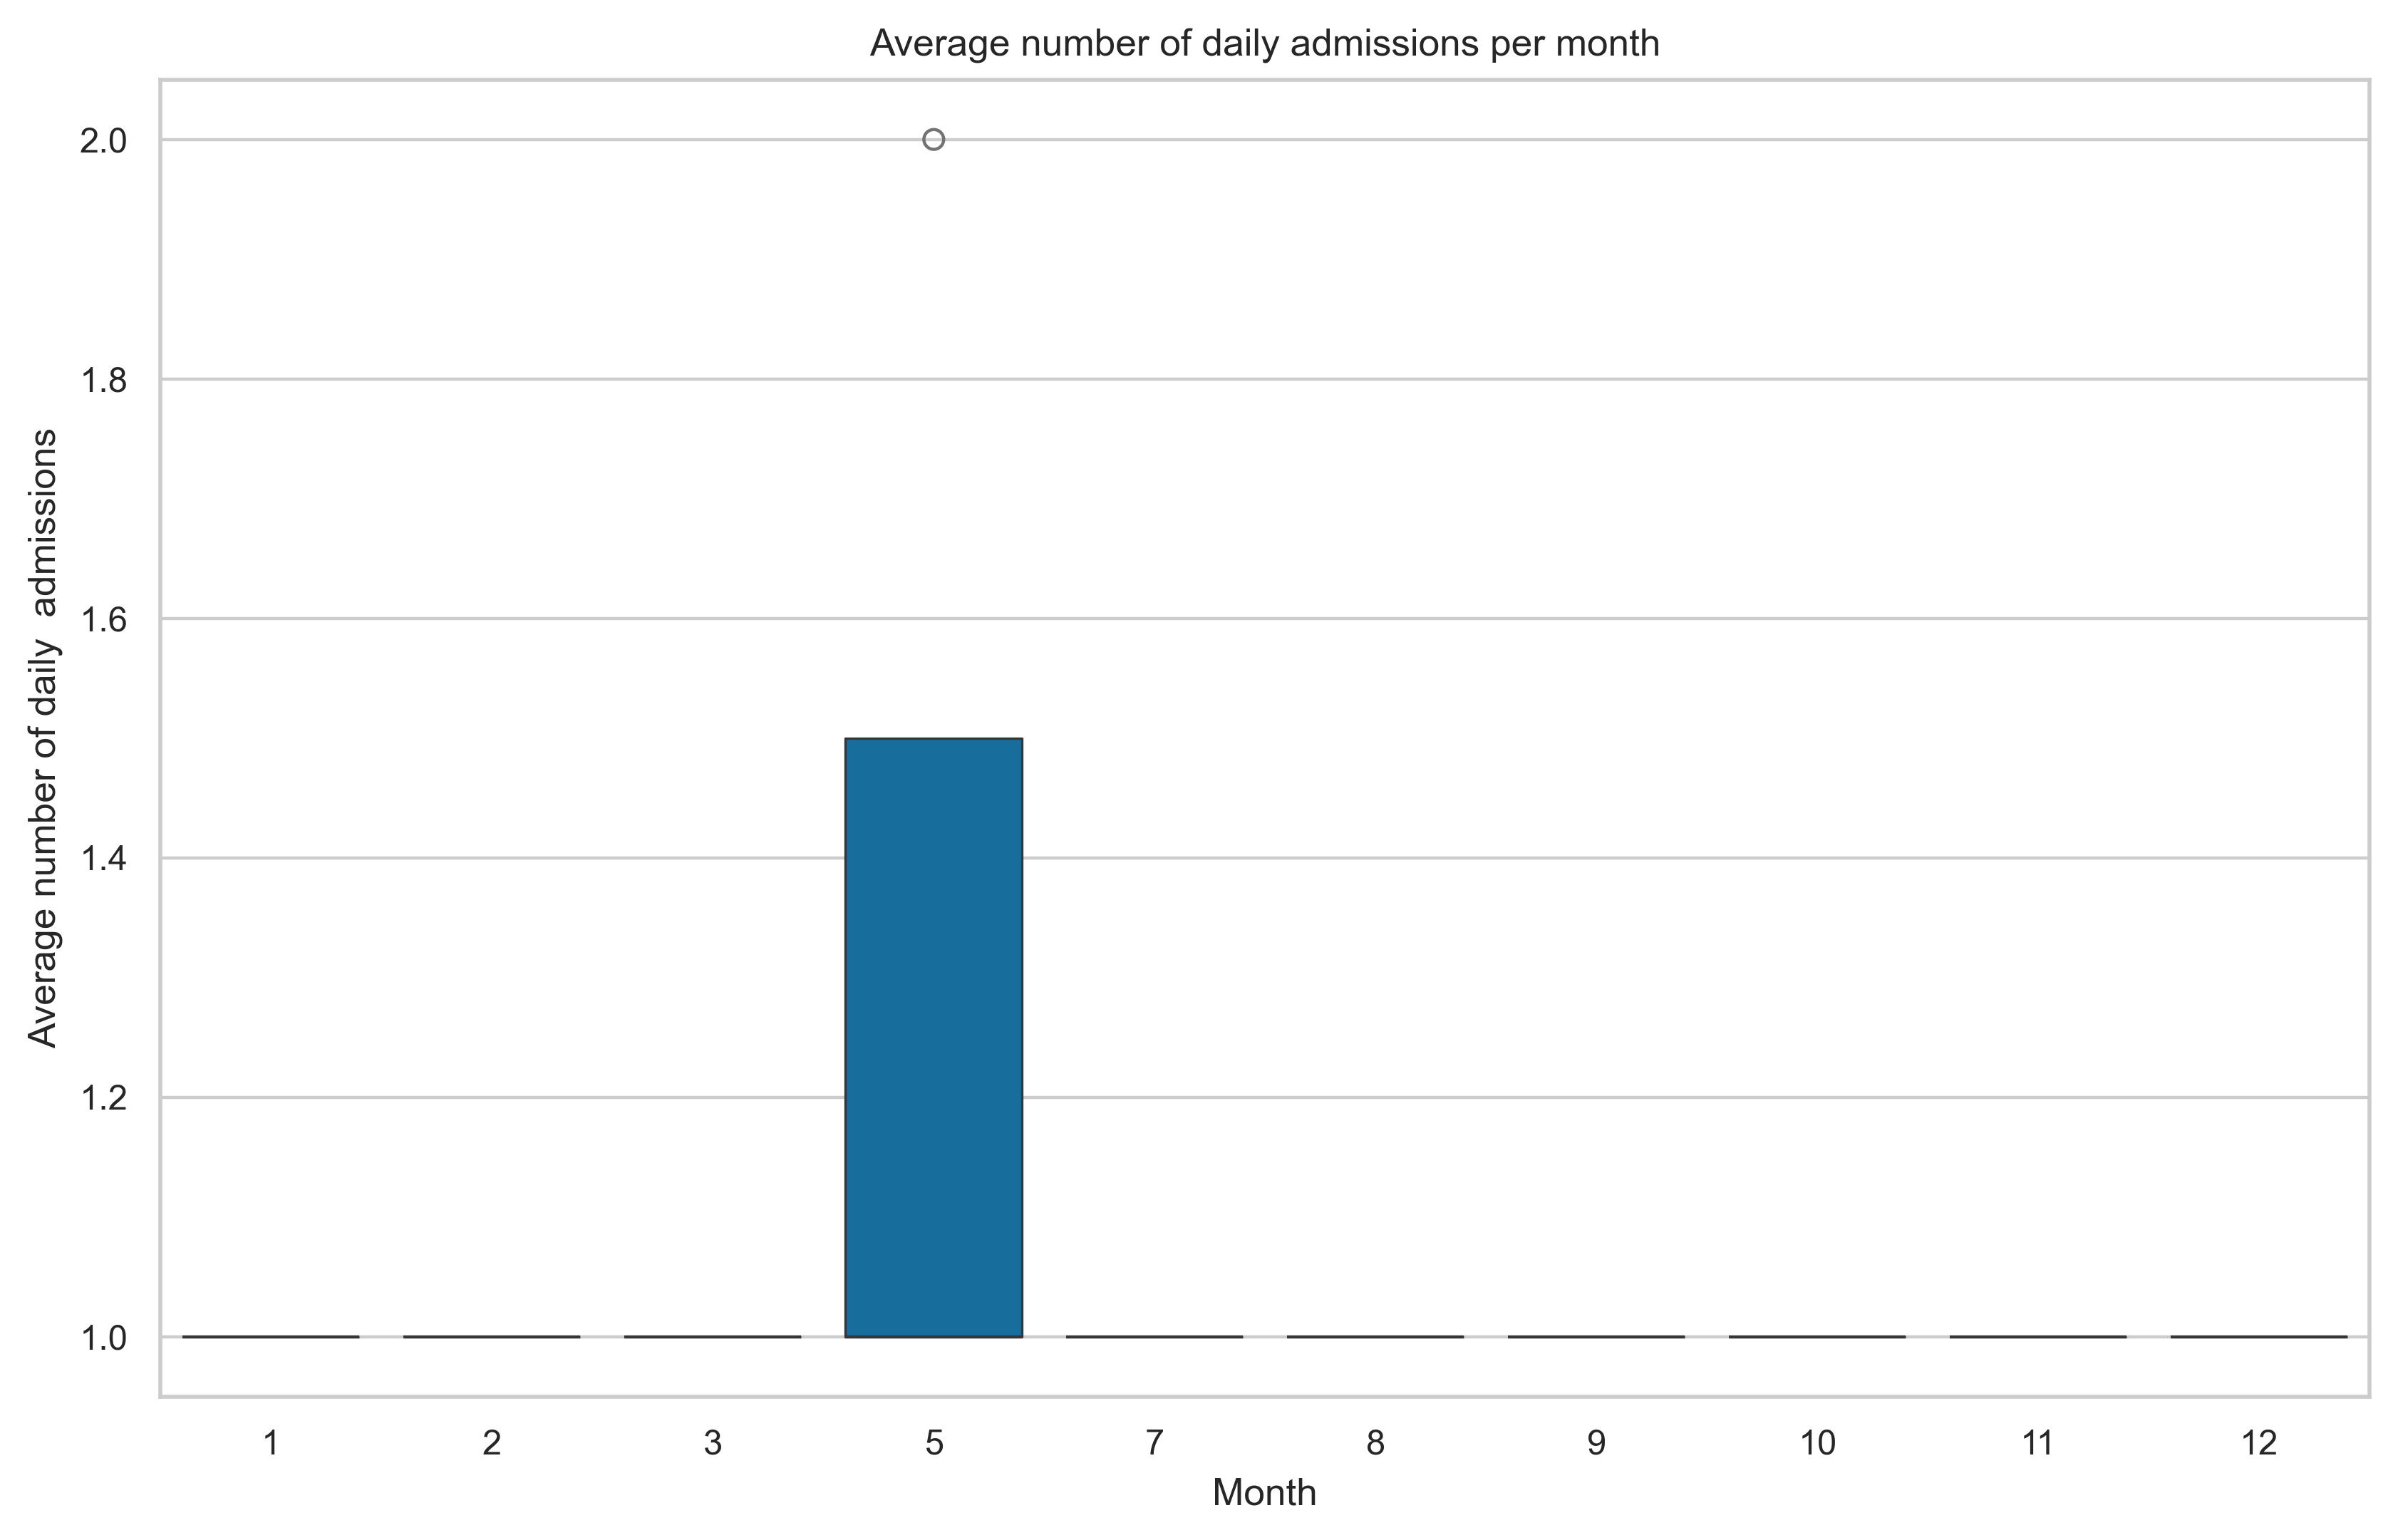

In [101]:
#average admissions per month
fig, ax = plt.subplots(figsize=(10, 6),dpi=400)
sns.boxenplot(data=daily_admissions_filtered, x='month', y='admissions', ax=ax)
plt.title('Average number of daily admissions per month')
plt.xlabel('Month')
plt.ylabel('Average number of daily  admissions')
plt.show()


In [103]:
# Conduct Kruskal-Wallis H test
months = daily_admissions_filtered['month'].unique()
month_groups = [daily_admissions_filtered[daily_admissions_filtered['month'] == month]['admissions'] for month in months]
stat, p = kruskal(*month_groups)
print('Kruskal-Wallis H test statistic:', stat)
print('p-value:', p)
 
if p < 0.05:
    print('The differences between seasons are statistically significant.')
else:
    print('The differences between seasons are not statistically significant.')

Kruskal-Wallis H test statistic: 6.000000000000067
p-value: 0.7399182920946471
The differences between seasons are not statistically significant.


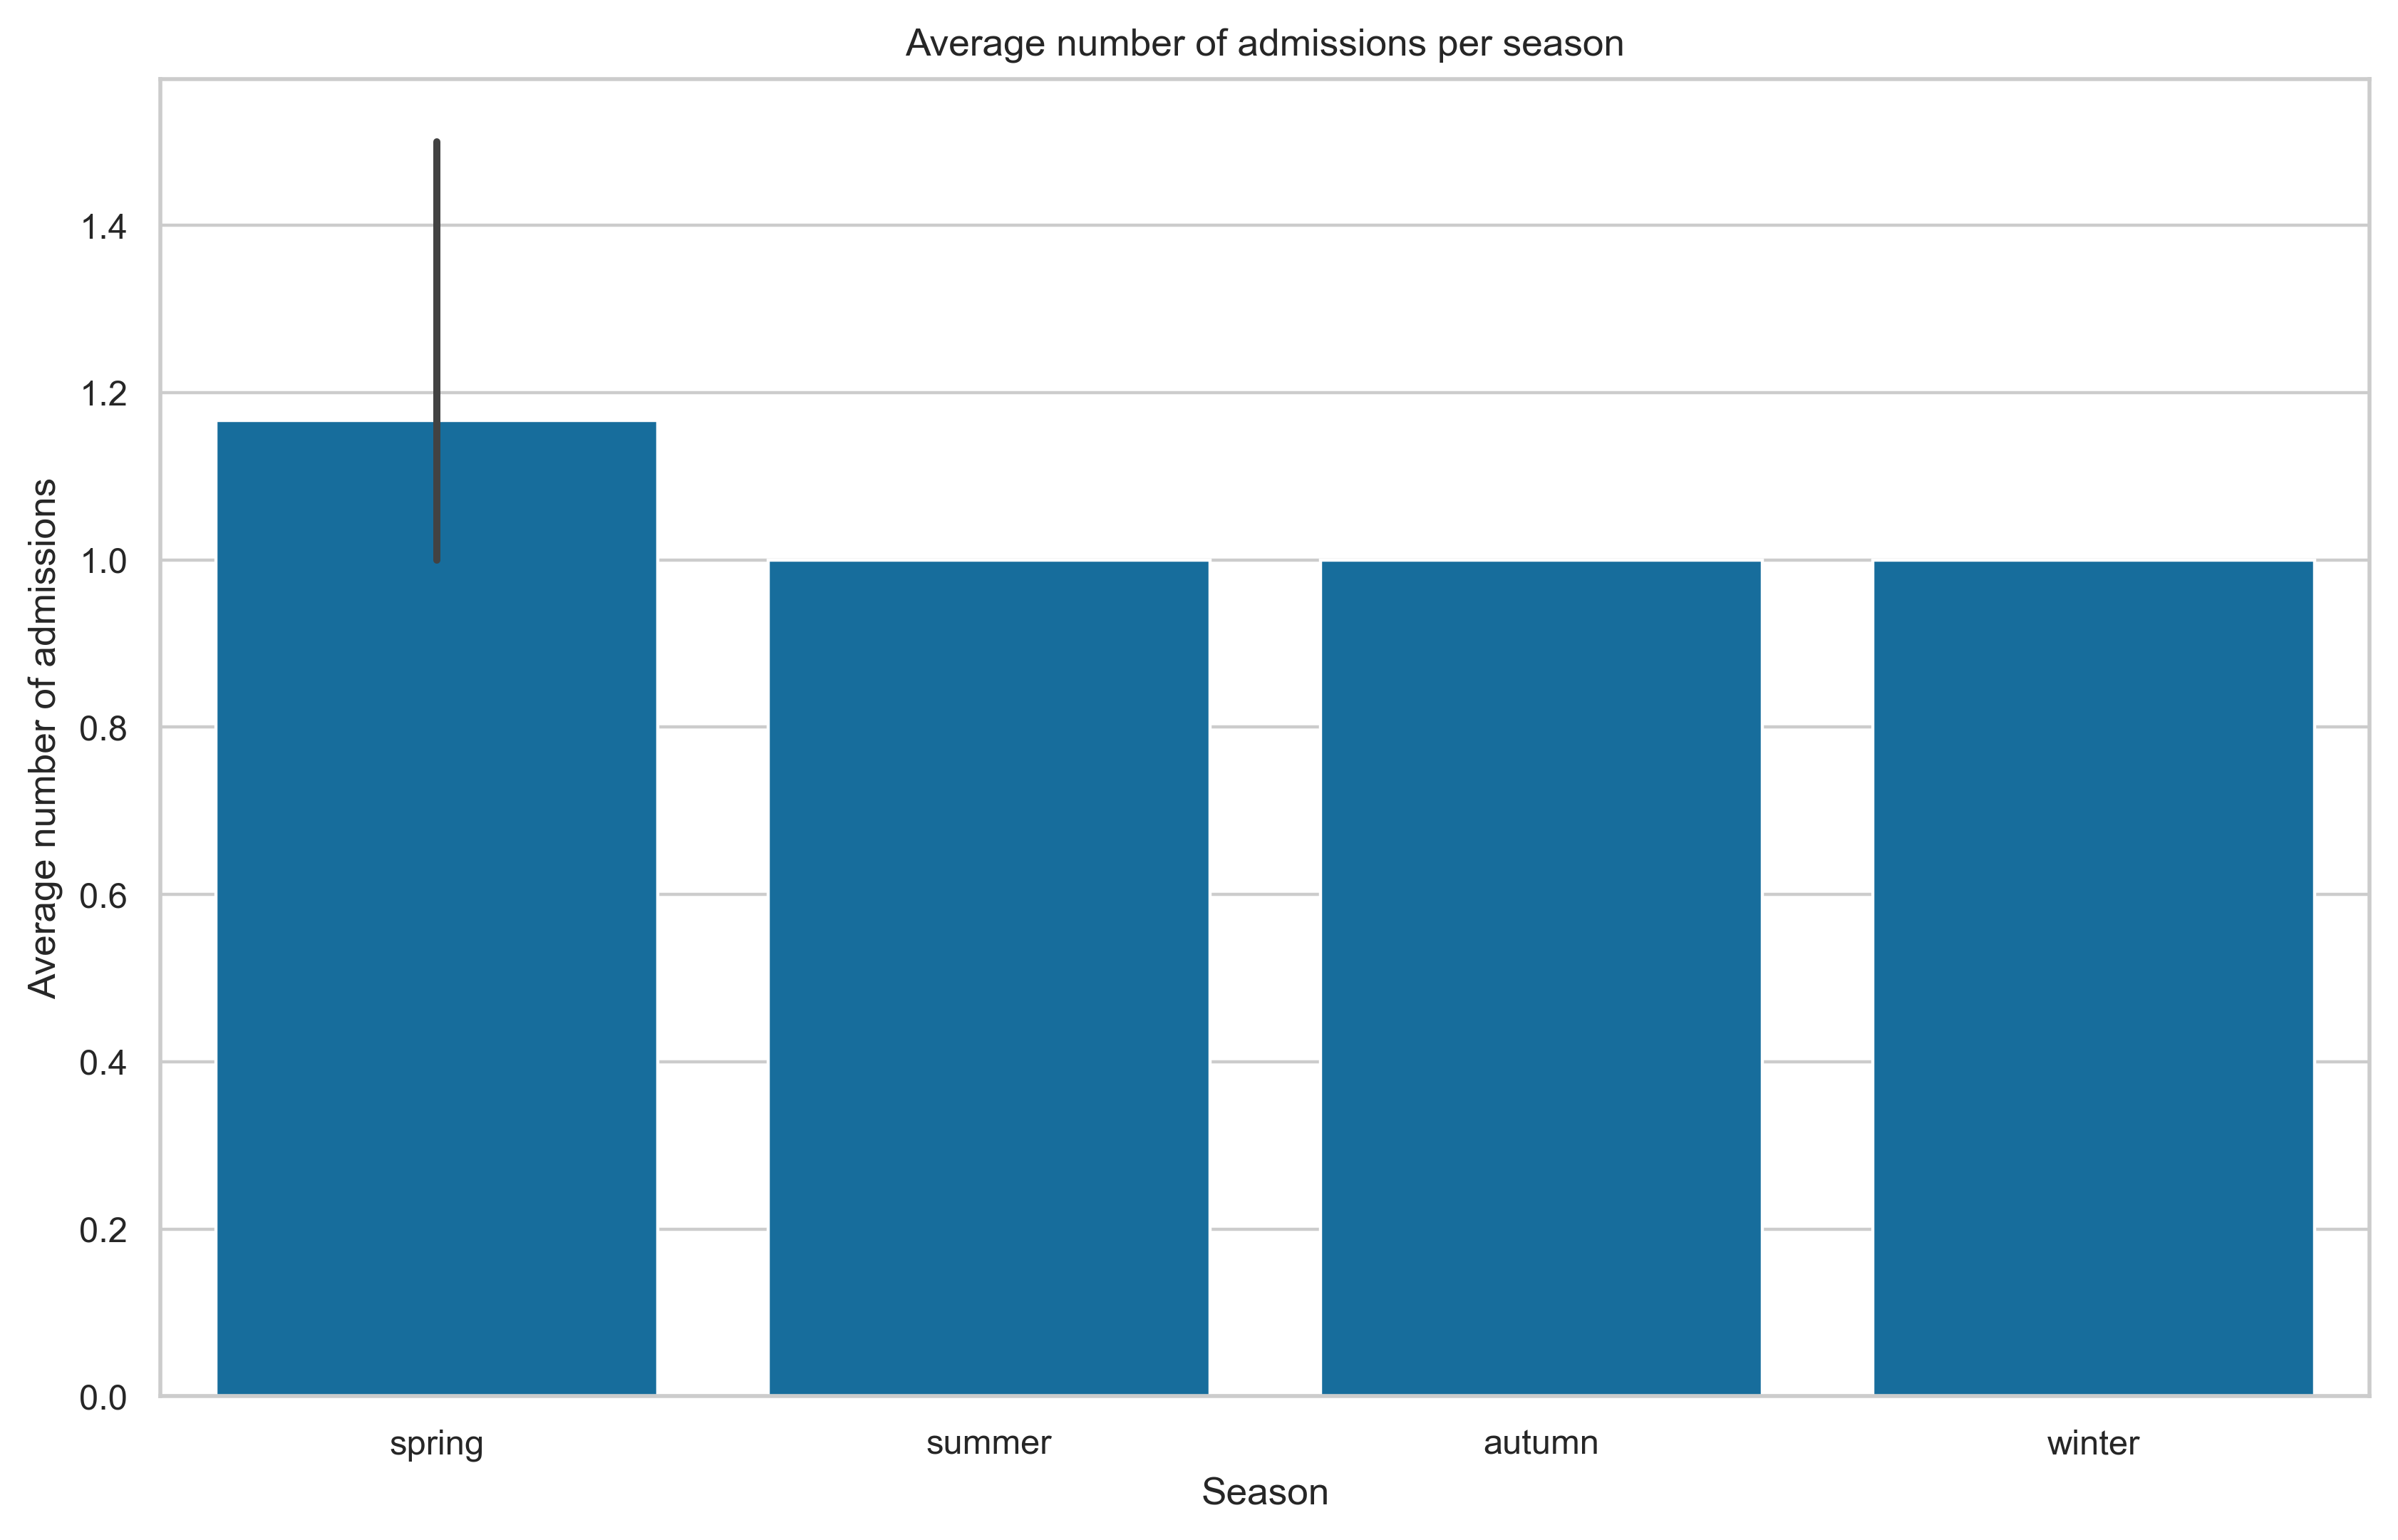

In [104]:
#average admission count per season
fig, ax = plt.subplots(figsize=(10, 6),dpi=400)
sns.barplot(data=daily_admissions_filtered, x='season', y='admissions', ax=ax)
plt.title('Average number of admissions per season')
plt.xlabel('Season')
plt.ylabel('Average number of admissions')
plt.show()


In [105]:
#average admissions per season in table
print(daily_admissions_filtered.groupby('season')['admissions'].describe())

        count      mean       std  min  25%  50%  75%  max
season                                                    
autumn    4.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
spring    6.0  1.166667  0.408248  1.0  1.0  1.0  1.0  2.0
summer    5.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
winter    6.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0


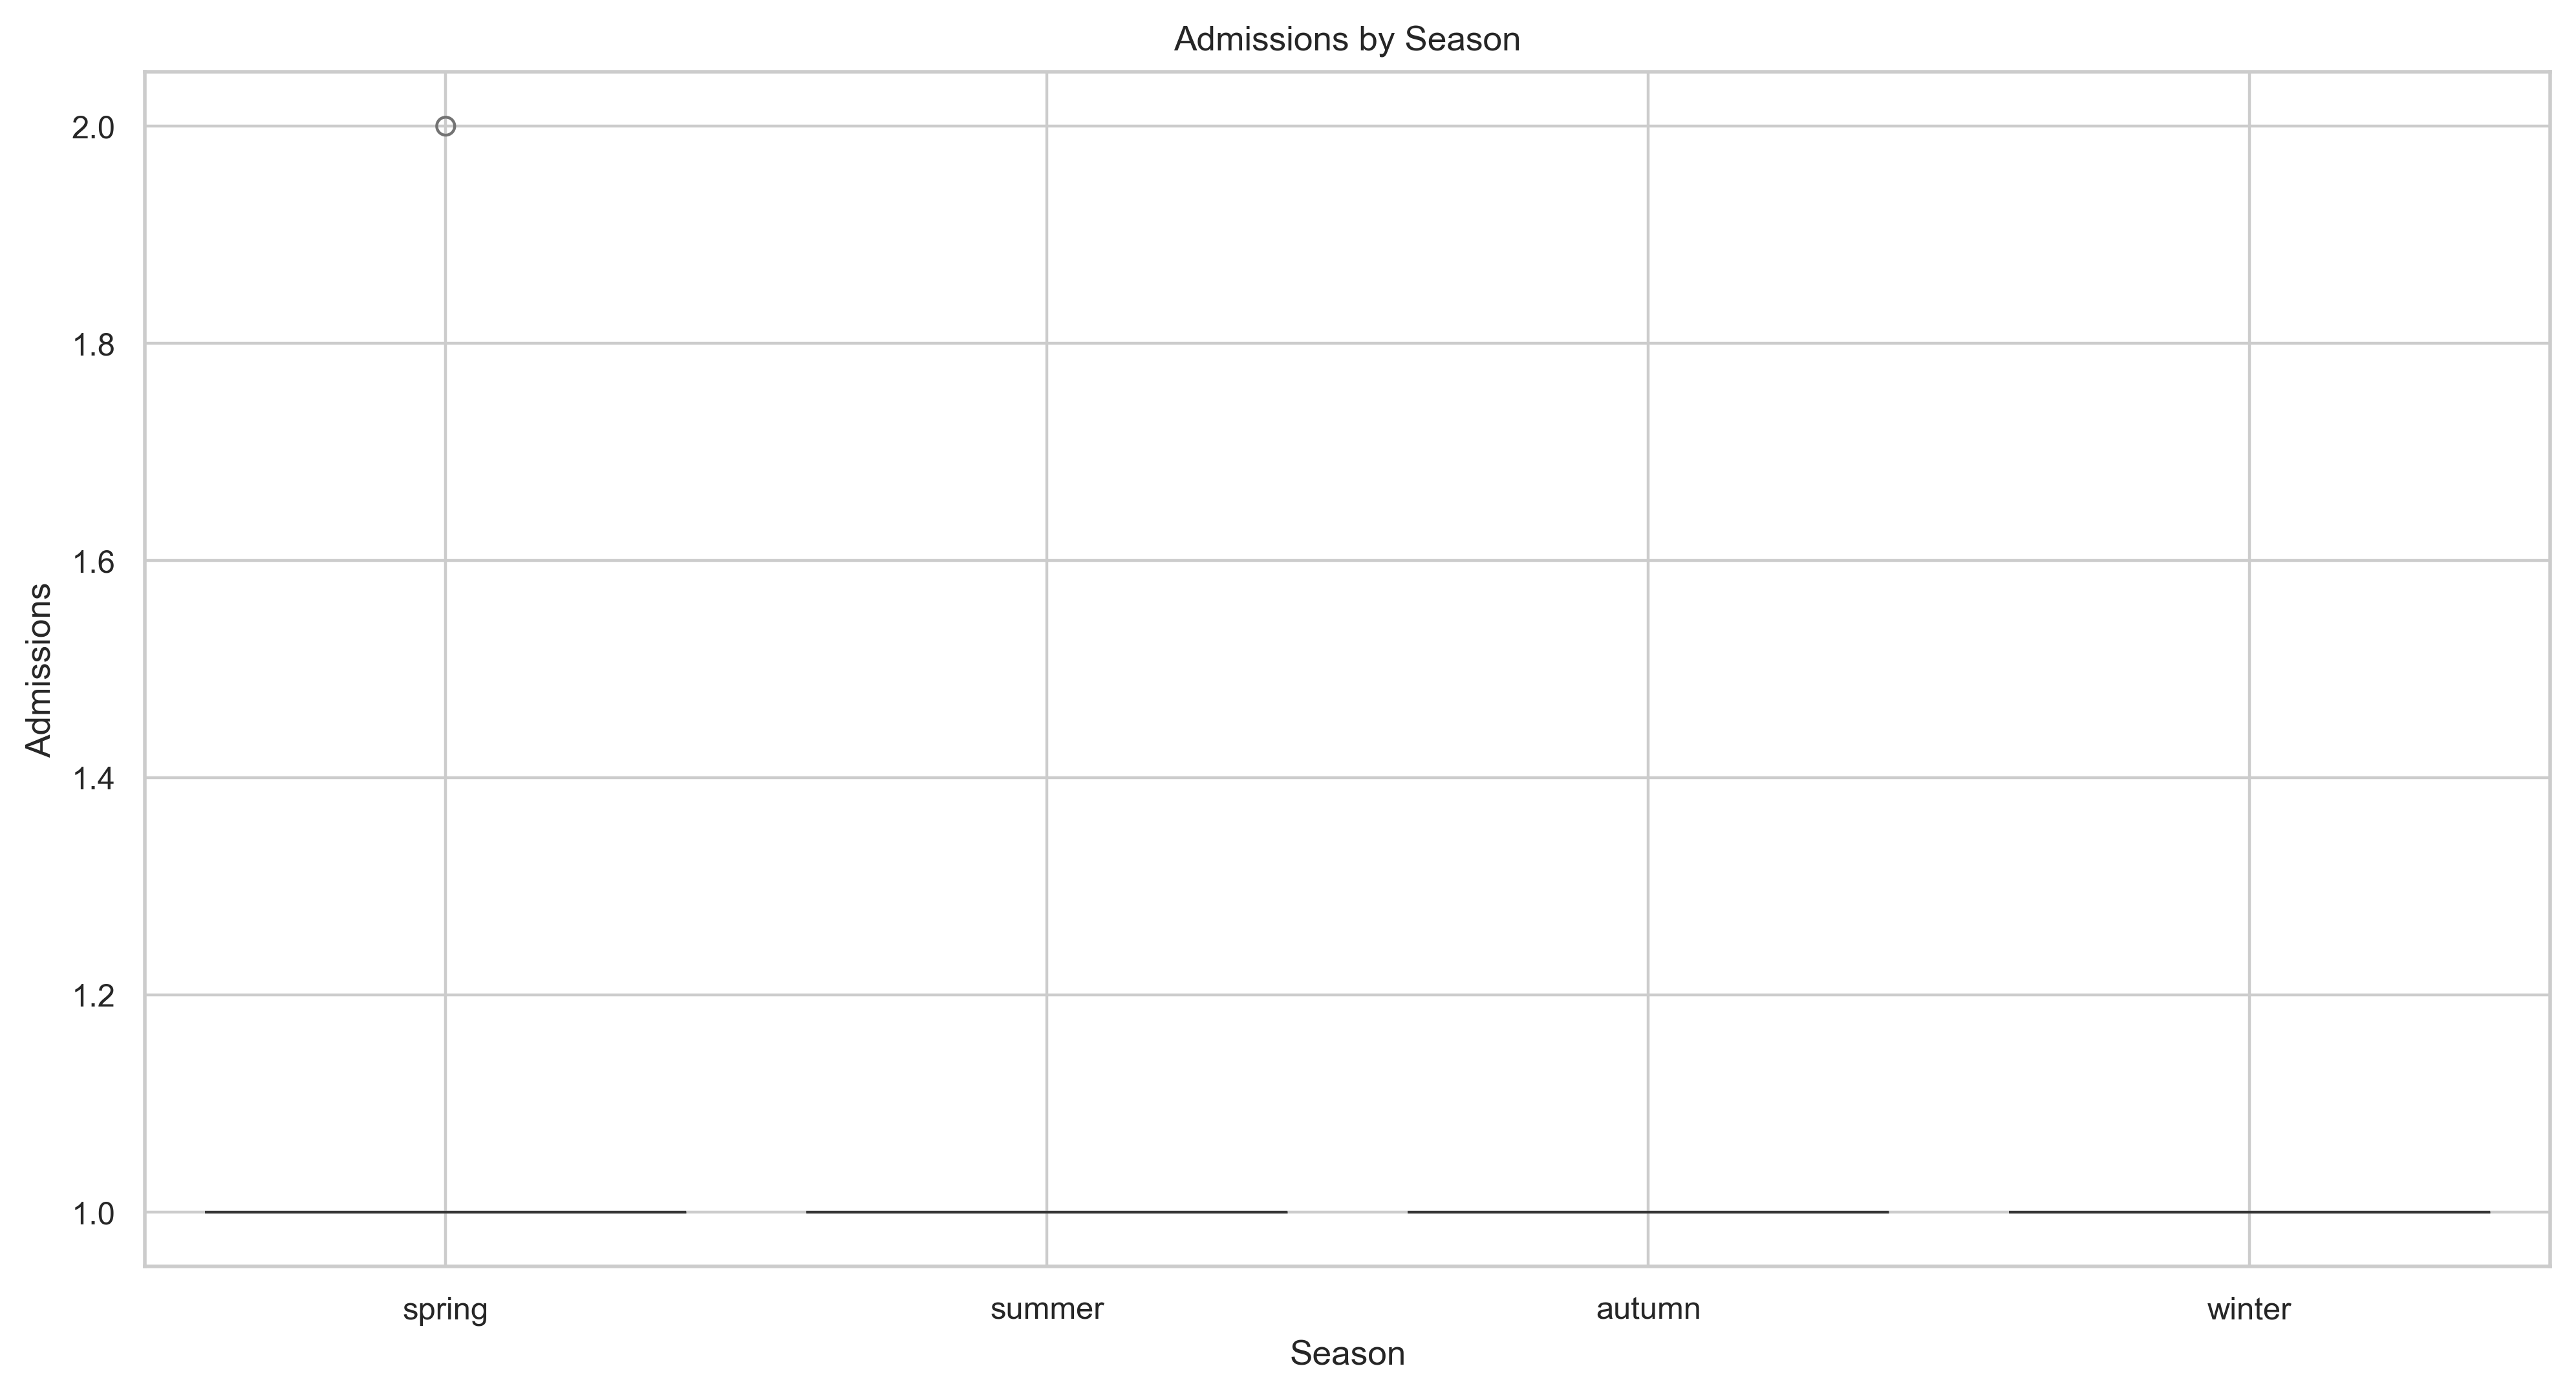

Kruskal-Wallis H test statistic: 2.500000000000019
p-value: 0.4752910833430172
The differences between seasons are not statistically significant.


In [106]:

from scipy.stats import kruskal


# Boxplot of admissions by season
plt.figure(figsize=(12, 6),dpi=400)
sns.boxenplot(x='season', y='admissions', data=daily_admissions_filtered)
plt.title('Admissions by Season')
plt.xlabel('Season')
plt.ylabel('Admissions')
plt.grid(True)
plt.show()
 
# Conduct Kruskal-Wallis H test
seasons = daily_admissions_filtered['season'].unique()
season_groups = [daily_admissions_filtered[daily_admissions_filtered['season'] == season]['admissions'] for season in seasons]
stat, p = kruskal(*season_groups)
print('Kruskal-Wallis H test statistic:', stat)
print('p-value:', p)
 
if p < 0.05:
    print('The differences between seasons are statistically significant.')
else:
    print('The differences between seasons are not statistically significant.')